**Purpose:** Extract the details about the current resources in the Galaxy Training Material and some statistics

In [70]:
import base64
import copy
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import yaml

from github import Github
from pprint import pprint


str(datetime.datetime.now())

'2019-11-05 10:04:22.243372'

Usage:
1. Generate a Personal access tokens on GitHub (in Setting)
2. Add it to the `../config.yaml` after `github:`

In [3]:
with open("../config.yaml", "r") as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

In [4]:
# connect to GitHub
g = Github(config["github"])
# retrieve the hub repository
repo = g.get_user("galaxyproject").get_repo("training-material")

In [81]:
# dates and corresponding commit
gitcommit_dates = {
    "22.06.17": "44164c9b",
    "22.06.18": "24ea24ef",
    "22.06.19": "4ae23d58",
    'today': "master"}

# Evolution of topics, tutorials and technical support

In [176]:
def has_zenodo(file_content):
    '''
    Check if Zenodo link in tutorial

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: boolean
    '''
    decoded_file_content = base64.b64decode(file_content)
    return 'zenodo_link' in str(decoded_file_content)


def is_enable(file_content):
    '''
    Check if tutorial is enabled or not link in tutorial

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: boolean
    '''
    decoded_file_content = base64.b64decode(file_content)
    return not 'enable: ' in str(decoded_file_content)


def get_topic_title(topic_n, ref):
    '''
    :param topic_n: name of the topic
    :param ref: name of the commit/branch/tag
    
    :return: title of the topic in metadata file
    '''
    metadata_f = repo.get_contents("topics/%s/metadata.yaml" % topic_n, ref)
    metadata_f_content = yaml.load(base64.b64decode(metadata_f.content), Loader=yaml.FullLoader)
    return metadata_f_content['title']
    

def extract_training_content(ref):
    '''
    Extract the details about the current resources in the Galaxy Training Material,
    and aggregate information per topics

    :param ref: name of the commit/branch/tag

    :return: dictionary with information about the tutorials (tutorial, slides, workflow, 
    data library) in each topic on ref and aggregated statistics per topics
    '''
    trainings = {}
    topics_dir = "topics"
    infos = {'slides': False, 'hands_on': False, 'workflows': False, 'data_library': False, 'zenodo': False}
    stat_c = {'introduction': 0, 'tutorials': 0, 'slides': 0, 'hands_on': 0, 'workflows': 0, 'zenodo': 0, 'data_library': 0}
    stats = pd.DataFrame(columns=list(stat_c.keys()), index=[])
    for topic in repo.get_dir_contents("topics", ref):
        # get topic details
        topic_n = topic.name
        topic_t = get_topic_title(topic_n, gitcommit_dates[d])
        # prepare aggregation for topic
        trainings.setdefault(topic_n, {})
        topic_stat = copy.copy(stat_c)
        # check for introduction
        for topic_c in repo.get_dir_contents("%s/" % topic.path, ref):
            if topic_c.name == 'slides':
                topic_stat['introduction'] += len(
                    repo.get_dir_contents("%s/slides/" % topic.path, ref))
        # parse the tutorials
        for tuto in repo.get_dir_contents("%s/tutorials/" % topic.path, ref):
            tuto_n = tuto.name
            enabled = True
            trainings[topic_n].setdefault(tuto_n, copy.copy(infos))
            # parse the files in the tuto folder
            for tuto_f in repo.get_dir_contents(tuto.path, ref):
                if tuto_f.name == 'slides.html':
                    trainings[topic_n][tuto_n]['slides'] = True
                    enabled = is_enable(tuto_f.content)
                elif tuto_f.name == 'tutorial.md':
                    trainings[topic_n][tuto_n]['hands_on'] = True
                    trainings[topic_n][tuto_n]['zenodo'] = has_zenodo(tuto_f.content)
                    enabled = is_enable(tuto_f.content)
                elif tuto_f.name == 'workflows':
                    trainings[topic_n][tuto_n]['workflows'] = True
                elif tuto_f.name == 'data-library.yaml':
                    trainings[topic_n][tuto_n]['data_library'] = True
            # aggregate stats if enable tutorial
            if enabled:
                topic_stat['tutorials'] += 1
                for c in topic_stat:
                    if c == 'tutorials' or c == 'introduction':
                        continue
                    if trainings[topic_n][tuto_n][c]:
                        topic_stat[c] += 1
        # add stats in table
        stats.loc[topic_t] = topic_stat
    # rename table columns
    stats = stats.rename(columns = {
        'introduction': 'Introduction slide decks',
        'tutorials': 'Tutorials',
        'slides': 'Slide decks',
        'hands_on': 'Hands-on tutorials',
        'workflows': 'Workflows',
        'zenodo': 'Data on Zenodo',
        'data_library': 'Data on data library'})         
            
    return trainings, stats    

In [177]:
# extract training content
training_contents = {}
stats_per_date = {}
global_stats = pd.DataFrame(columns=[], index=[])
for d, git_com in gitcommit_dates.items():
    training_contents[d], stats_per_date[d] = extract_training_content(git_com)
    aggr_stats = (stats_per_date[d]
                  .sum()
                  .add(pd.Series([len(training_contents[d])], index=['Topics']), fill_value=0)
                  .to_frame(name=d))
    global_stats = pd.concat([global_stats, aggr_stats], axis=1)
# format table
global_stats = (global_stats
    .reindex(['Topics', 'Introduction slide decks', 'Tutorials', 'Slide decks', 'Hands-on tutorials', 'Workflows', 'Data on Zenodo', 'Data on data library'])
    .astype(int))

Topics, number of tutorials and technical support per dates (22.06.17, 22.06.18, 22.06.19, today)

In [173]:
stats_per_date['22.06.17']

,Introduction slides,Tutorials,Slide decks,Hands-on tutorials,Workflows,Data on Zenodo,Data on data library
Galaxy Server administration,1,4,2,2,0,0,0
Assembly,0,2,2,2,1,0,2
ChIP-Seq data analysis,1,2,0,2,1,0,1
Development in Galaxy,1,13,12,4,0,0,0
Epigenetics,1,1,0,1,1,0,1
Galaxy Introduction,1,8,2,6,0,0,8
Metagenomics,1,2,0,2,2,0,2
Proteomics,1,7,0,7,7,0,6
Analysis of sequences,1,7,2,7,7,0,7
Train the trainers,1,6,1,5,0,1,5


In [178]:
stats_per_date['22.06.18']

,Introduction slide decks,Tutorials,Slide decks,Hands-on tutorials,Workflows,Data on Zenodo,Data on data library
Galaxy Server administration,1,9,7,4,0,0,0
Assembly,0,4,3,4,2,0,3
ChIP-Seq data analysis,1,2,0,2,2,0,2
Contributing to the Galaxy Training Material,1,13,3,11,0,2,0
Development in Galaxy,1,13,12,4,0,0,0
Epigenetics,1,2,0,2,2,0,1
Genome Annotation,0,2,1,2,2,0,2
Introduction to Galaxy,1,13,2,11,0,0,8
Metagenomics,1,2,0,2,2,0,2
Proteomics,1,8,0,8,8,0,6


In [179]:
stats_per_date['22.06.19']

,Introduction slide decks,Tutorials,Slide decks,Hands-on tutorials,Workflows,Data on Zenodo,Data on data library
Galaxy Server administration,1,28,24,13,0,7,0
Assembly,0,4,3,4,4,4,4
ChIP-Seq data analysis,1,1,1,1,1,1,1
Computational chemistry,0,3,0,3,2,3,0
Contributing to the Galaxy Training Material,1,10,2,9,1,3,0
Development in Galaxy,1,12,12,3,0,0,0
Epigenetics,1,2,0,2,2,2,2
Data Manipulation,0,6,1,5,0,5,0
User Interface and Features,0,3,0,3,0,3,1
Genome Annotation,1,3,1,3,2,3,3


In [180]:
stats_per_date['today']

,Introduction slide decks,Tutorials,Slide decks,Hands-on tutorials,Workflows,Data on Zenodo,Data on data library
Galaxy Server administration,1,31,24,16,0,6,0
Assembly,0,4,3,4,4,4,4
Computational chemistry,0,4,0,4,3,4,0
Contributing to the Galaxy Training Material,1,10,2,9,1,3,0
Development in Galaxy,1,13,12,4,0,0,0
Ecology,0,5,0,5,4,4,4
Epigenetics,2,5,2,5,5,5,4
Data Manipulation,0,7,1,6,0,6,0
User Interface and Features,0,4,0,4,1,4,1
Genome Annotation,1,4,2,4,2,4,4


Global informations

In [181]:
global_stats

,22.06.17,22.06.18,22.06.19,today
Topics,13,14,19,20
Introduction slide decks,13,11,11,11
Tutorials,63,86,134,153
Slide decks,21,31,51,53
Hands-on tutorials,49,68,105,124
Workflows,23,32,57,69
Data on Zenodo,1,2,86,99
Data on data library,36,38,53,60


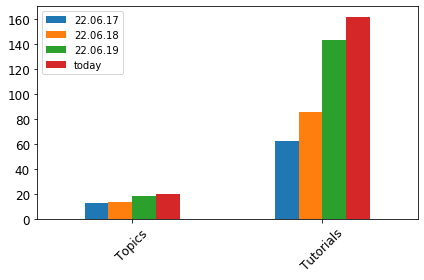

In [150]:
content_stats = global_stats.loc[['Topics', 'Tutorials']]
# plot barplot stats
ax = content_stats.plot(kind='bar', legend=True, fontsize=12)
ax.set_xticklabels(content_stats.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/topic_stat_plot.png", transparent=True, dpi=150)

# Contributors

In [155]:
def get_contributors(ref):
    '''
    Extract the list of contributor at a given git commit

    :param ref: name of the commit/branch/tag

    :return: set with contributor ids
    '''
    file_content = repo.get_contents("CONTRIBUTORS.yaml", ref=ref).content
    decoded_file_content = base64.b64decode(file_content)
    yaml_content = yaml.load(decoded_file_content, Loader=yaml.FullLoader)
    contributors = set(yaml_content.keys())
    return contributors

In [159]:
contributors = {}
contr_stats = pd.DataFrame(columns=['Number of contributors'], index=[])
for d, git_com in gitcommit_dates.items():
    if d == '22.06.17':
        continue
    contributors[d] = get_contributors(git_com)
    contr_stats.loc[d] = {'Number of contributors': len(contributors[d])}

In [160]:
contr_stats

,Number of contributors
22.06.18,77
22.06.19,122
today,141


# Contributions